#### This notebook add temperature and PCA fields to embryo metadata

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os
from glob2 import glob

In [5]:
# load embryo_df for our current best model
# root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/"

root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/"
train_name = "20241107_ds"
model_name = "SeqVAE_z100_ne150_sweep_01_block01_iter030" 
train_dir = os.path.join(root, "training_data", train_name, "")
output_dir = os.path.join(train_dir, model_name) 

# get path to model
training_path = sorted(glob(os.path.join(output_dir, "*")))[-1]
training_name = os.path.dirname(training_path)
read_path = os.path.join(training_path, "figures", "")

# path to figures and data
# fig_root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/slides/morphseq/20250213/"
fig_path = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/slides/morphseq/20250312/morph_metrics/"
os.makedirs(fig_path, exist_ok=True)

In [6]:
fig_path

"/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/slides/morphseq/20250312/morph_metrics/"

In [7]:
morph_df = pd.read_csv(read_path + "embryo_stats_df.csv", index_col=0)
umap_df = pd.read_csv(read_path + "umap_df.csv", index_col=0)
morph_df.head()

/var/folders/m7/tpjttxb92tl8b4c9svgvgby00000gn/T/ipykernel_40312/583710703.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  morph_df = pd.read_csv(read_path + "embryo_stats_df.csv", index_col=0)
/var/folders/m7/tpjttxb92tl8b4c9svgvgby00000gn/T/ipykernel_40312/583710703.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  umap_df = pd.read_csv(read_path + "umap_df.csv", index_col=0)


,snip_id,embryo_id,experiment_time,experiment_date,temperature,medium,short_pert_name,control_flag,phenotype,predicted_stage_hpf,...,UMAP_01_n_2,UMAP_00_3,UMAP_01_3,UMAP_02_3,UMAP_00_bio_3,UMAP_01_bio_3,UMAP_02_bio_3,UMAP_00_n_3,UMAP_01_n_3,UMAP_02_n_3
0,20230525_A03_e00_t0001,20230525_A03_e00,594.316650,20230525,22.0,EM,wt_wik,0,wt,15.105656,...,-2.311100,7.520212,10.468943,11.171429,11.298864,10.072700,10.614341,9.100211,-3.534792,-4.300537
1,20230525_A03_e00_t0002,20230525_A03_e00,3591.278076,20230525,22.0,EM,wt_wik,0,wt,15.638449,...,-2.686945,8.170442,10.853229,10.748030,11.062443,10.279505,9.276375,9.134713,-4.185889,-4.422592
2,20230525_A03_e00_t0003,20230525_A03_e00,6591.527710,20230525,22.0,EM,wt_wik,0,wt,16.171827,...,-2.885924,8.539273,10.993577,10.317668,10.528914,10.705087,8.589877,9.127588,-4.285573,-4.554633
3,20230525_A03_e00_t0004,20230525_A03_e00,9596.864624,20230525,22.0,EM,wt_wik,0,wt,16.706109,...,-3.478214,8.835723,11.208259,10.091439,10.133465,11.015662,7.580985,9.361564,-4.792571,-4.667296
4,20230525_A03_e00_t0005,20230525_A03_e00,12591.573975,20230525,22.0,EM,wt_wik,0,wt,17.238502,...,-3.564565,8.834275,11.239143,9.971113,9.949432,11.247446,7.242141,9.413491,-4.849039,-4.722008


### We need to add temperature metadata from well map files

In [8]:
# subset for hotfish experiments
HF_experiments = np.asarray(['20240813_24hpf', '20240813_30hpf', '20240813_36hpf', '20240813_extras'])
hf_morph_df = morph_df.loc[np.isin(morph_df["experiment_date"], HF_experiments), :].reset_index()

# extract well info
exp_vec = hf_morph_df.loc[:, "experiment_date"].to_numpy()
eid_vec = hf_morph_df.loc[:, "embryo_id"].to_numpy()
well_list = np.asarray([eid.split("_")[-2] for eid in eid_vec])
hf_morph_df["well_id"] = well_list
letter_index = np.asarray(["A", "B", "C", "D", "E", "F", "G", "H"])

# load plate maps 
metadata_dir = os.path.join(root, "metadata", "well_metadata", "")
df_list = []
for exp in HF_experiments:
    # Construct the file path: e.g., "metadata/morphseq_maps/20240813_24hpf.xlsx"
    file_path = os.path.join(metadata_dir, f"{exp}_well_metadata.xlsx")
    
    # Read the "temperature" sheet from the Excel file into a DataFrame.
    temp_df = pd.read_excel(file_path, sheet_name="temperature", index_col=0)

    well_list = []
    temp_list = []
    for i in range(temp_df.shape[0]):
        for j in range(temp_df.shape[1]):
            well_list.append(letter_index[i] + f"{j+1:02}")
            temp_list.append(temp_df.iloc[i,j])

    df = pd.DataFrame(well_list, columns=["well_id"])
    df["temp"] = temp_list
    df["experiment_date"] = exp
    df_list.append(df)

temp_df = pd.concat(df_list, ignore_index=True)

temp_df.head()

,well_id,temp,experiment_date
0,A01,NaN,20240813_24hpf
1,A02,19.0,20240813_24hpf
2,A03,25.0,20240813_24hpf
3,A04,28.5,20240813_24hpf
4,A05,32.0,20240813_24hpf


In [9]:
# get snip IDs for the relevant embryos and update metadata
print(temp_df.shape)
temp_df = temp_df.merge(hf_morph_df.loc[:, ["experiment_date", "well_id", "snip_id"]], how="left", on=["experiment_date", "well_id"])
print(temp_df.shape)
snip_id_vec = temp_df["snip_id"].to_numpy()
temp_vec = temp_df["temp"].to_numpy()

# update
for s, snip_id in enumerate(snip_id_vec):
    # update the main morph df
    morph_df.loc[morph_df["snip_id"] == snip_id, "temperature"] = temp_vec[s]
    
# umap df
if "temperature" in umap_df.columns.tolist():
    umap_df = umap_df.drop(labels=["temperature"], axis=1)
umap_df = umap_df.merge(morph_df.loc[:, ["snip_id", "temperature"]], how="left", on="snip_id")

(384, 3)
(384, 4)


#### Calculate PCA to complement UMAP info

In [14]:
from sklearn.decomposition import PCA

# get cols
morph_cols = morph_df.columns.tolist()
full_cols = [col for col in morph_cols if "z_mu" in col]
bio_cols = [col for col in morph_cols if "z_mu_b" in col]
nbio_cols = [col for col in morph_cols if "z_mu_n" in col]

# initialize
n_components_b = 10
n_components_n = 5

pca_full = PCA(n_components=n_components_b)
pca_bio = PCA(n_components=n_components_b)
pca_nbio = PCA(n_components=n_components_n)

# fit
pca_full.fit(morph_df.loc[:, full_cols])
pca_bio.fit(morph_df.loc[:, bio_cols])
pca_nbio.fit(morph_df.loc[:, nbio_cols])

# reduce
pca_array_full = pca_full.transform(morph_df.loc[:, full_cols])
pca_array_bio = pca_bio.transform(morph_df.loc[:, bio_cols])
pca_array_nbio = pca_nbio.transform(morph_df.loc[:, nbio_cols])

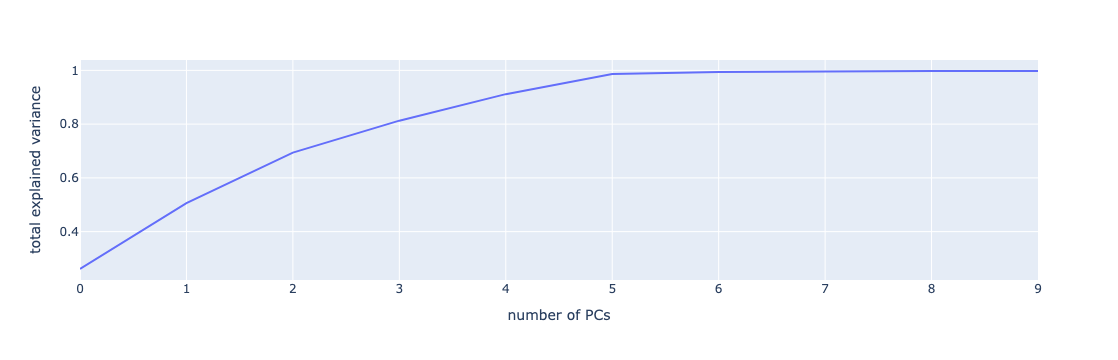

In [16]:
# plot cumulative expllained variance
var_exp = pca_bio.explained_variance_ratio_
var_exp_c = np.cumsum(var_exp)

fig = px.line(x=np.arange(n_components_b), y=var_exp_c)
fig.update_layout(xaxis=dict(title="number of PCs"),
                  yaxis=dict(title="total explained variance"))
fig.show()
fig.write_image(os.path.join(fig_path, "pc_plot.png"))

In [18]:
# get col names
pca_cols_full = [f"PCA_{p:02}_all" for p in range(n_components_b)]
pca_cols_bio = [f"PCA_{p:02}_bio" for p in range(n_components_b)]
pca_cols_nbio = [f"PCA_{p:02}_nbio" for p in range(n_components_n)]

# update UMAP df
umap_df.loc[:, pca_cols_full] = pca_array_full
umap_df.loc[:, pca_cols_bio] = pca_array_bio  
umap_df.loc[:, pca_cols_nbio] = pca_array_nbio

In [19]:
# save
morph_df.to_csv(read_path + "embryo_stats_df.csv")
umap_df.to_csv(read_path + "umap_df.csv")